In [1]:
# %load_ext autoreload
# %autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('./ml-fairness-gym'))
if module_path not in sys.path:
    sys.path.append(module_path)

from environments import infectious_disease as id
from experiments import infectious_disease as ide
from agents import infectious_disease_agents as ida
import util

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(["science", "grid", "notebook"])
# plt.style.use("default")

2022-03-04 15:54:17.693122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/evanlavender/miniconda3/envs/machine-learning/lib/python3.8/site-packages/cv2/../../lib64:
2022-03-04 15:54:17.693149: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Params(transition_matrix=array([[0., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]]), treatment_transition_matrix=array([[0, 0, 1],
       [0, 1, 0],
       [0, 0, 1]]), state_names=['susceptible', 'infected', 'recovered'], healthy_index=0, infectious_index=1, healthy_exit_index=1, infection_probability=0.75, population_graph=<networkx.classes.graph.Graph object at 0x7f9a2e1c5f70>, initial_health_state=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], initial_health_state_seed=27, num_treatments=1, max_treatments=1, burn_in=0)


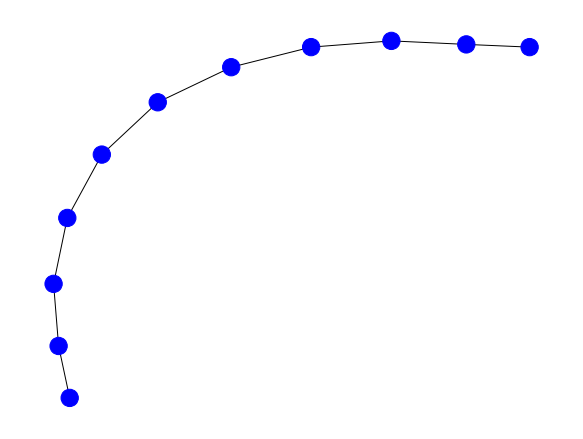

In [2]:
np.random.seed(13)

TAU   = 0.75
RHO   = 1.0
ide.GRAPHS["chain"] = nx.generators.path_graph(11)

EXP = ide.Experiment()
EXP.graph_name = "chain"
EXP.infection_probability     = TAU
EXP.infected_exit_probability = RHO
EXP.num_treatments = 1
EXP.burn_in = 0
EXP.agent_constructor = ide.NullAgent
EXP.scenario_builder()
print(EXP.env.initial_params)

positions = nx.spring_layout(EXP.env.initial_params.population_graph, seed=13)
color_map = ["blue", "red", "purple"]
EXP.env.render(color_map, pos=positions)

In [3]:
EXP.num_steps = 10
N = 1000

EXP.agent_constructor = ide.NullAgent
null_metrics = util.run_simulations(N, EXP)

EXP.agent_constructor = ida.MiddleAgent
mid_metrics = util.run_simulations(N, EXP)

EXP.agent_constructor = ide.RandomAgent
rng_metrics = util.run_simulations(N, EXP)

EXP.agent_constructor = ida.PrecisionAgent_CHAIN
pre_metrics = util.run_simulations(N, EXP)

EXP.agent_constructor = ida.PrecisionRandomAgent
prr_metrics = util.run_simulations(N, EXP)

100%|██████████| 1000/1000 [00:44<00:00, 22.47it/s]


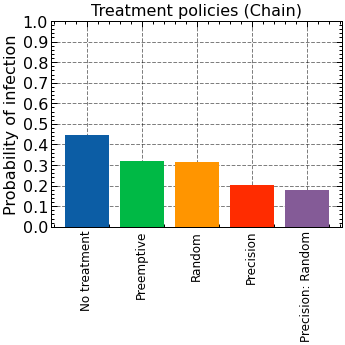

In [75]:
metrics = [null_metrics, mid_metrics, rng_metrics, pre_metrics, prr_metrics]
labels = ["No treatment", "Preemptive", "Random", "Precision", "Precision: Random"]

plt.figure(figsize=(5, 5))
plt.title("Treatment policies (Chain)")
plt.ylabel("Probability of infection")
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylim(bottom=0.0, top=1.0)
plt.tick_params(axis="x", labelsize=12)
for metric, label in zip(metrics, labels):
    plt.bar(label, np.mean(metric["num_sickdays"]) / N)
plt.tight_layout()
plt.savefig("out/nb-chain-sickdays.jpg")
plt.show()

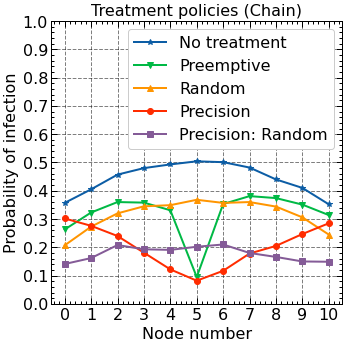

In [74]:
marks = ["-*", "-v", "-^", "-o", "-s"]

plt.figure(figsize=(5, 5))
plt.title("Treatment policies (Chain)")
plt.xlabel("Node number")
plt.ylabel("Probability of infection")
plt.ylim(bottom=0.0, top=1.0)
plt.xticks(range(11))
plt.yticks(np.arange(0, 1.1, step=0.1))
for metric, label, mark in zip(metrics, labels, marks):
    num_sickdays = metric["num_sickdays"] / N
    plt.plot(range(num_sickdays.shape[0]), num_sickdays, mark, label=label)
plt.legend()
plt.tight_layout()
plt.savefig("out/nb-chain-probinfect.jpg")
plt.show()

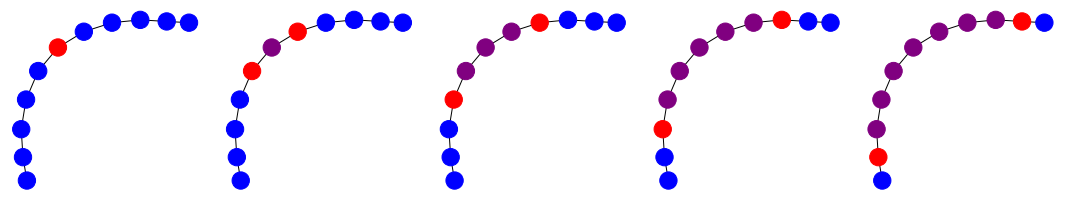

In [43]:
EXP.scenario_builder()
# Choose a single patient at random to be sick.
initial_health_state = [0 for _ in EXP.env.initial_params.initial_health_state]
initial_health_state[5] = 1
# print("patient0", patient0)
EXP.env.set_initial_health_state(initial_health_state)
EXP.env.reset()

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
for i in range(5):
    EXP.env.render(color_map, pos=positions, ax=ax[i])
    EXP.env.step(None)
fig.tight_layout()
fig.savefig("out/nb-chain-demo.jpg")